In [0]:
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

In [0]:
vgg = models.vgg19(pretrained=True).features
for param in vgg.parameters():
    param.requires_grad_(False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg = vgg.to(device)

In [0]:
def load_image(img_path, max_size=400, shape=None):
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape: size = shape
        
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    # discard the transparent, alpha channel | add the batch dimension
    return transform(image)[:3, :, :].unsqueeze(0)

In [0]:
content = load_image('https://ichef.bbci.co.uk/images/ic/1376x774/p075hvwf.jpg').to(device)
style = load_image('https://i1.wp.com/aksankaart.ru/wp-content/uploads/2019/07/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg?resize=1140%2C641', shape=content.shape[-2:]).to(device)

In [0]:
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image

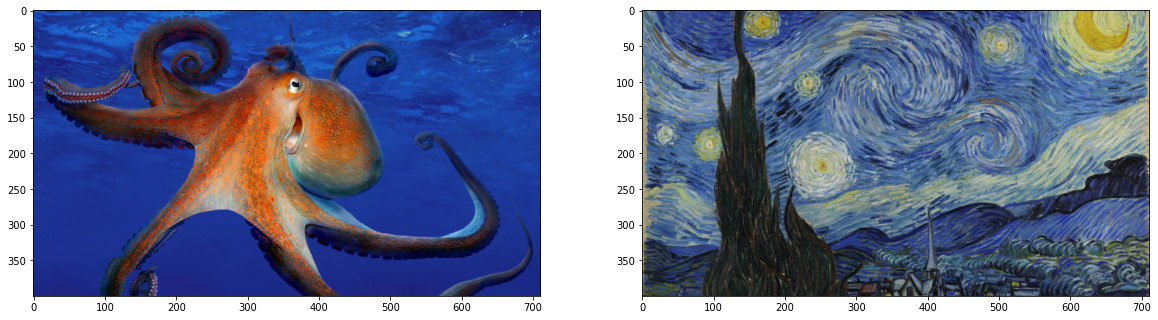

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [0]:
def get_features(image, model, layers):       
    features = {}
    for name, layer in model._modules.items():
        image = layer(image)
        if name in layers:
            features[layers[name]] = image
    return features

In [0]:
def gram_matrix(tensor):
    bs, d, h, w = tensor.size()  # bs = 1
    tensor = tensor.view(bs * d, h * w)
    return torch.mm(tensor, tensor.t())

In [0]:
content_layer = 'conv4_2'
vgg_layers = {
    '0': 'conv1_1',
    '5': 'conv2_1', 
    '10': 'conv3_1', 
    '19': 'conv4_1',
    '21': content_layer,
    '28': 'conv5_1',
}
content_features = get_features(content, vgg, vgg_layers)
style_features = get_features(style, vgg, vgg_layers)
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
# starting with copy of content
target = content.clone().requires_grad_(True).to(device)

In [0]:
style_weights = {
    'conv1_1': 1.,
    'conv2_1': 0.75,
    'conv3_1': 0.2,
    'conv4_1': 0.2,
    'conv5_1': 0.2,
}
content_weight = 1
style_weight = 1e6

epoch: 400/2000


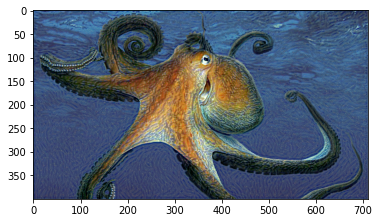

epoch: 800/2000


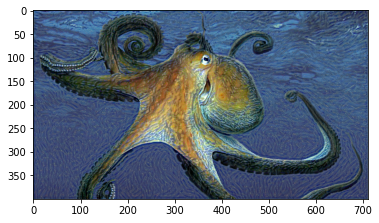

epoch: 1200/2000


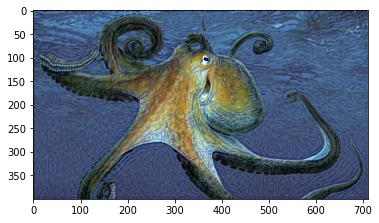

epoch: 1600/2000


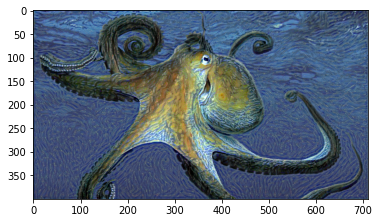

epoch: 2000/2000


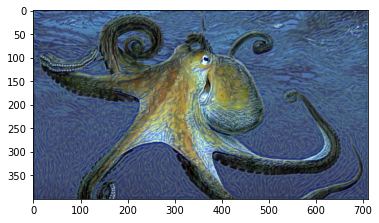

In [14]:
from tqdm.auto import tqdm
show_every = 400
optimizer = optim.Adam([target], lr=0.005)
steps = 2000


for step in tqdm(range(1, steps+1)):
    
    target_features = get_features(target, vgg, vgg_layers)
    content_loss = torch.mean((target_features[content_layer] - content_features[content_layer])**2)
    style_loss = 0

    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_loss += layer_style_loss / (d * h * w)
        
    total_loss = content_weight * content_loss + style_weight * style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if step % show_every == 0:
        print(f"epoch: {step}/{steps}")
        plt.imshow(im_convert(target))
        plt.show()

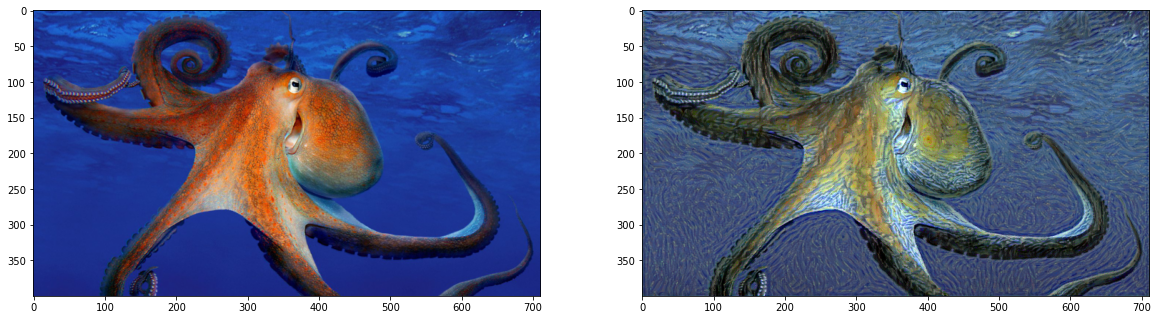

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))